In [58]:
import pandas as pd
stop_trip_combinations = pd.read_csv('C:/Users/HP/Downloads/stop_times_df.csv', index_col=0)
stop_trip_combinations['dep_time'] = pd.to_timedelta(stop_trip_combinations['arrival_time_dt']).dt.total_seconds()
stop_trip_combinations['arr_time'] = pd.to_timedelta(stop_trip_combinations['departure_time_dt']).dt.total_seconds()
stop_trip_combinations = stop_trip_combinations[['trip_id', 'stop_id', 'dep_time', 'arr_time']]
stop_trip_combinations.sort_values(by=['trip_id', 'arr_time'])
stop_trip_combinations.head()

,trip_id,stop_id,dep_time,arr_time
0,143.TA.91-15-B-j24-1.1161.H,8501120:0:1,71040.0,70860.0
1,143.TA.91-1-M-j24-1.50.R,8501117:0:3,82500.0,82440.0
2,143.TA.91-1-M-j24-1.50.R,8501118:0:4,82680.0,82620.0
3,143.TA.91-1-M-j24-1.50.R,8518452:0:2,82800.0,82800.0
4,143.TA.91-1-M-j24-1.50.R,8501120:0:6,83100.0,83100.0


In [59]:
timetable_obs = []
stop_trip_combinations_n = len(stop_trip_combinations)
for i in range(stop_trip_combinations_n-1):
    if stop_trip_combinations.iloc[i]['trip_id'] == stop_trip_combinations.iloc[i+1]['trip_id']:
        timetable_obs.append([stop_trip_combinations.iloc[i]['stop_id'], stop_trip_combinations.iloc[i+1]['stop_id'], stop_trip_combinations.iloc[i]['dep_time'], stop_trip_combinations.iloc[i+1]['arr_time'], stop_trip_combinations.iloc[i]['trip_id']])
timetable = pd.DataFrame(timetable_obs, columns=['dep_stop', 'arr_stop', 'dep_time', 'arr_time', 'trip_id'])
timetable['connection_id'] = timetable.groupby('trip_id').cumcount() + 1
timetable['connection_id'] = timetable['connection_id'].astype(str) + '_' + timetable['trip_id']
timetable = timetable.sort_values(by='arr_time')

In [60]:
timetable.to_csv('timetable.csv', index=False)
timetable.head()

,dep_stop,arr_stop,dep_time,arr_time,trip_id,connection_id
5303,8504003:0:1,8504010:0:2,5160.0,5280.0,22.TA.91-3N-Y-j24-1.175.R,1_22.TA.91-3N-Y-j24-1.175.R
9204,8504003:0:2,8504010:0:2,5160.0,5280.0,30.TA.91-3N-Y-j24-1.49.R,1_30.TA.91-3N-Y-j24-1.49.R
6677,8504003:0:2,8504010:0:2,5160.0,5280.0,25.TA.91-3N-Y-j24-1.98.R,1_25.TA.91-3N-Y-j24-1.98.R
7627,8504003:0:1,8504010:0:2,5160.0,5280.0,27.TA.91-3N-Y-j24-1.68.R,1_27.TA.91-3N-Y-j24-1.68.R
4502,8504003:0:1,8504010:0:2,5160.0,5280.0,21.TA.91-3N-Y-j24-1.139.R,1_21.TA.91-3N-Y-j24-1.139.R


In [79]:
source_stop_id = '8592060'
destination_stop_id = '8591984'

# A tuple x dominates a tuple y if 
#       there is no component in which y is strictly smaller than x 
#       and 
#       there is a component in which x is strictly smaller than y
def x_dominates_y(x, y):
    if y[0] < x[0]:
        return False
    if y[1] < x[1]:
        return False
    if x[0] < y[0]:
        return True
    if x[1] < y[1]:
        return True
    return False # catches case where pairs exactly equal
    

# prepare data and S, T arrays
# S: arrays of (dep_time, arr_time) tuples. S[x] contains xt-profile
# T: array of ints. int = earliest arrival time for partial journey departing in earliest scanned connection of trip
timetable_decreasing = timetable.sort_values(by='dep_time', ascending=False)
S = {key: [(float('inf'), float('inf'))] for key in set(list(timetable['dep_stop']) + list(timetable['arr_stop']))}
T = {key: float('inf') for key in set(timetable['trip_id'])}

# for each connection (in decreasing time of arrival order)
for index, row in timetable_decreasing.iterrows():

    # t1 = arrival time when connection arrives at destination station
    if row['arr_stop'] == destination_stop_id: 
        intra_station_walking = 0 # assume intra-station walking isn't a thing right now...
        t_1 = row['arr_time'] + intra_station_walking
    else:
        t_1 = float('inf')
    
    # t2 = arrival time when remaining seated, uses T[c_trip]
    t_2 = T[row['trip_id']]

    # arrival time when transferring, uses S[c_arr_stop]
    i = 0 # earlier time = earlier index in this array
    p = S[row['arr_stop']][i]
    while p[0] < row['arr_time']: # loop purpose: find earliest previously seen connection's departure time that is after currently seen connection's arrival time
        i += 1
        p = S[row['arr_stop']][i]
    t_3 = p[1]

    # t_c = the earliest arrival time of our three possible options
    t_c = min(t_1, t_2, t_3)

    # if current connection dominates previously seen earliest departure-arrival pair for this stop, put to head of S for this stop
    p = (row['dep_time'], t_c)
    q = S[row['dep_stop']][0]
    if x_dominates_y(q, p) == False:
        if q[0] != p[0]:
            S[row['dep_stop']] = [p] + S[row['dep_stop']]
        else:
            S[row['dep_stop']][0] = p
    
    # new earliest arrival for partial journey departing from this trip's earliest scanned connection
    T[row['trip_id']] = t_c

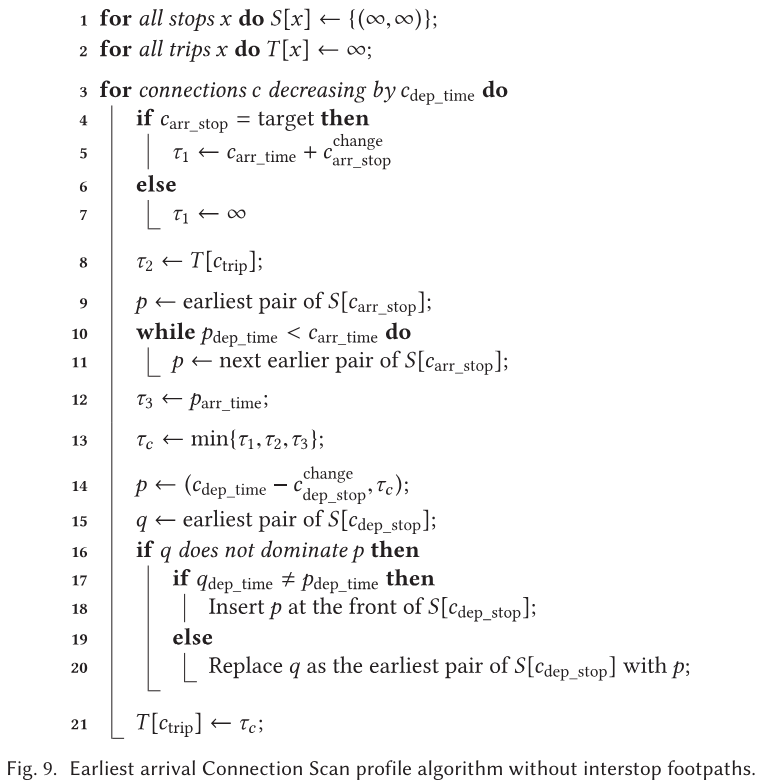

In [46]:
from IPython.display import display, Image
display(Image(filename='profile_connection_scan_algo.png'))